In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from scipy.signal import spectrogram

In [8]:
# Folder with (preprocessed and filtered) epochs
preproc_folder_epochs = 'b2/folder_epochs' 

# Folder with the sliced epochs (contains info on KMEANS-clustered epochs) 
sliced_folder_epochs = 'b2/folder_epochs/sliced_epochs_KMEANS' 

# Define channels that have signal (-0 for python indexing)
channels_interest = ['EEG 3', 'EEG 4', 'EEG 11', 'EEG 12'] 
# Corresponding channel names    
channel_names = ['OFC_right', 'S_right', 'S_left', 'OFC_left' ] 

# Define all subjects present
all_animals = ['8.1', '8.2', '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '8.10', '8.11', '8.12', '8.13', '8.14', '8.15', '8.16']


In [5]:
# Define stuff for plotting

# Define custom palette
custom_palette = {
    'Saline': '#f6b48f',
    'CNO1': '#e13342',
    'CNO5': '#ad1759',
    'CNO10': '#701f57'
}

# Define the order of channels and legend treatments
channel_order = ['OFC_left', 'OFC_right', 'S_left', 'S_right']
legend_order = ['Saline', 'CNO1', 'CNO5', 'CNO10']

# Define duration of hours to plot
duration_hours = 2

In [9]:
# BATCH 1
# Create dataframe
df = pd.DataFrame()

# Loop through all files in the raw epoch folder
for preproc_filename in os.listdir(preproc_folder_epochs):
    if not preproc_filename.endswith('epo.fif'):
        continue        

    preproc_file_path = os.path.join(preproc_folder_epochs, preproc_filename)
    preproc_data = mne.read_epochs(preproc_file_path, 
                                   preload=False)
    
    for sliced_filename in os.listdir(sliced_folder_epochs):
        if not sliced_filename.endswith("epo.fif"):
            continue

        if preproc_filename in sliced_filename:
            # Read sliced epochs:
            sliced_epochs = mne.read_epochs(os.path.join(sliced_folder_epochs, sliced_filename), preload=False)
            print(f"Selected sliced epochs: {sliced_filename}")
            print(f"Selected preprocessed epochs: {preproc_filename}")
        
            # # select 1 hr instead of 2hrs epochs
            # start_timepoint = 0 # Index of epoch. 

            # duration_epochs = duration_hours * 60 * 12  # 60 minutes/hour * 12 epochs/minute
            # end_timepoint = start_timepoint + duration_epochs
            # sliced_epochs = sliced_epochs[start_timepoint:end_timepoint]

            # Slice preprocessed file based on the index of the metadata of the sliced_epochs
            sliced_preproc = preproc_data[sliced_epochs.metadata.index]
            sliced_preproc.metadata = pd.concat([sliced_preproc.metadata, sliced_epochs.metadata["Cluster_Label"]], axis=1)

            # Replace treatment names for consistency
            replacement_map = {
            'cno1': 'CNO1',
            'cno5': 'CNO5',
            'cno5-2': 'CNO5',
            'cno10': 'CNO10',
            'saline2': 'Saline',
            'Saline2': 'Saline',
            'Saline3': 'Saline'}

            for old_value, new_value in replacement_map.items():
                sliced_preproc.metadata['Treatment'] = sliced_preproc.metadata['Treatment'].replace([old_value], new_value)

            # Replace surgery names for consistency
            sliced_preproc.metadata['Surgery'] = sliced_preproc.metadata['Surgery'].replace('mcherry', 'mCherry')
            sliced_preproc.metadata['Surgery'] = sliced_preproc.metadata['Surgery'].replace('DREADD', 'DREADDs')

            # Get info from metadata
            animal_id = sliced_preproc.metadata['Animal'].unique()[0]
            treatment = sliced_preproc.metadata['Treatment'].unique()[0]
            surgery = sliced_preproc.metadata['Surgery'].unique()[0]
            cluster_label = sliced_preproc.metadata['Cluster_Label']
            sfreq = sliced_preproc.info['sfreq']

            print(f"Selected: {animal_id} {treatment}")
            # Match is found, break inner loop
            break

    # Calculate psds, relative psd for each cluster and channel               
    for channel, ch_name in zip(channels_interest, channel_names):
        for cl in ['High_70Hz', 'Low_70Hz']:
            # Exract cluster epochs
            cluster_epochs = sliced_preproc[sliced_preproc.metadata['Cluster_Label']==cl]

            # Calculate the PSD for all datasets  
            psds, freqs = mne.time_frequency.psd_array_multitaper(cluster_epochs.get_data(channel), fmin=0, fmax=100, sfreq=sfreq)
            mean_psd = np.mean(psds[:, 0, :], axis=0)
            median_psd = np.median(psds[:, 0, :], axis=0)

            # Calculate total power, relative PSD and mean relative PSD
            total_power = np.sum(psds, axis=-1)        
            rel_psd = psds / total_power[:, np.newaxis]
            mean_rel_psd = np.mean(rel_psd[:, 0, :], axis=0)
            median_rel_psd = np.median(rel_psd[:, 0, :], axis=0)

            # Create temporary df
            temp = pd.DataFrame({'Channel': ch_name,'Freqs': freqs, 'Mean_PSD': mean_psd, 'Mean_rel_PSD': mean_rel_psd, 
                                'Median_PSD': median_psd, 'Median_rel_PSD': median_rel_psd, 
                                'Animal': animal_id, 'Surgery': surgery, 'Treatment': treatment, 
                                'Cluster_Label': cl
                                })
            print(f'got temp: {animal_id} {treatment}')

            # Concatenate temp to full df
            df = pd.concat([df, temp])
         


Reading C:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b2\folder_epochs\epochs_preprocessed_TAINI_1019_B2_8.11_LR_DREADDs_leftsidecage_CNO10_2024-02-27_09-53-28_0000_NewTransmitter_1019_raw-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4999.45 ms
        0 CTF compensation matrices available
Reading C:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b2\folder_epochs\epochs_preprocessed_TAINI_1019_B2_8.11_LR_DREADDs_leftsidecage_CNO10_2024-02-27_09-53-28_0000_NewTransmitter_1019_raw-epo-1.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4999.45 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
17450 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\lisan\OneDrive\Bureaublad\RP\EEG_analysis_PharmCNO\b2\folder_epochs\sliced_epochs_KMEANS\sliced_sliced_epochs_preprocessed_TAINI_1019_B2_8.11_LR_DREADDs_left

In [12]:
print(f'sliced_preproc indices of epochs: {sliced_epochs.metadata.index}')

sliced_preproc indices of epochs: Index([ 900,  901,  902,  903,  904,  905,  906,  907,  909,  910,
       ...
       2318, 2320, 2323, 2324, 2325, 2326, 2328, 2329, 2330, 2334],
      dtype='int32', length=1165)


In [13]:
# Filter out animals to be excluded
df = df[~df['Animal'].isin(['8.13', '8.1', '8.10'])]

In [16]:
# Check if all animals and treatments are included
df[['Animal', 'Treatment']].drop_duplicates()

,Animal,Treatment
0,8.11,CNO10
0,8.11,CNO5
0,8.11,Saline
0,8.9,CNO1
0,8.9,CNO5
0,8.9,Saline
0,8.12,CNO10
0,8.12,CNO1
0,8.12,CNO5
0,8.12,Saline


In [42]:
# Save the full dataframe
df.to_excel('Title.xlsx')

Calculate relative to saline

In [17]:
# Calculate mean PSD saline for KMEANS cluster High_70Hz
norm_df_high = pd.DataFrame()
for channel in channel_names:
    eeg = df[(df['Channel']==channel) & (df['Cluster_Label']=='High_70Hz')]
    x = eeg.loc[eeg['Treatment'] == 'Saline', ['Freqs', 'Mean_PSD', 'Animal']].groupby(['Animal', 'Freqs']).mean()
    eeg = eeg.merge(x, on=['Animal','Freqs'], suffixes=('', '_saline'))
    eeg['normalized_power'] = eeg['Mean_PSD'] / eeg['Mean_PSD_saline']*100
    norm_df_high = pd.concat([norm_df_high, eeg])

# Calculate mean PSD saline for KMEANS cluster Low_70Hz
norm_df_low = pd.DataFrame()
for channel in channel_names:
    eeg = df[(df['Channel']==channel) & (df['Cluster_Label']=='Low_70Hz')]
    x = eeg.loc[eeg['Treatment'] == 'Saline', ['Freqs', 'Mean_PSD', 'Animal']].groupby(['Animal', 'Freqs']).mean()
    eeg = eeg.merge(x, on=['Animal','Freqs'], suffixes=('', '_saline'))
    eeg['normalized_power'] = eeg['Mean_PSD'] / eeg['Mean_PSD_saline']*100
    norm_df_low = pd.concat([norm_df_low, eeg])


# Subset for dreadds & mcherry, high & low clusters
dreadd_norm_high = norm_df_high[norm_df_high['Surgery']=='DREADDs'].drop_duplicates()
dreadd_norm_low = norm_df_low[norm_df_low['Surgery']=='DREADDs'].drop_duplicates()

mcherry_norm_high = norm_df_high[norm_df_high['Surgery']=='mCherry'].drop_duplicates()
mcherry_norm_low = norm_df_low[norm_df_low['Surgery']=='mCherry'].drop_duplicates()

In [26]:
dreadd_norm_high

,Channel,Freqs,Mean_PSD,Mean_rel_PSD,Median_PSD,Median_rel_PSD,Animal,Surgery,Treatment,Cluster_Label,Mean_PSD_saline,normalized_power
0,OFC_right,0.000000,4.149625e-07,0.002571,2.778090e-07,0.001790,8.11,DREADDs,CNO10,High_70Hz,5.092112e-07,81.491237
2,OFC_right,0.000000,3.557200e-07,0.002239,2.365148e-07,0.001494,8.11,DREADDs,CNO5,High_70Hz,5.092112e-07,69.857068
3,OFC_right,0.000000,5.092112e-07,0.002790,3.013806e-07,0.001823,8.11,DREADDs,Saline,High_70Hz,5.092112e-07,100.000000
4,OFC_right,0.199985,8.235818e-07,0.005119,6.006264e-07,0.004058,8.11,DREADDs,CNO10,High_70Hz,1.069813e-06,76.983727
6,OFC_right,0.199985,7.484255e-07,0.004657,5.417293e-07,0.003470,8.11,DREADDs,CNO5,High_70Hz,1.069813e-06,69.958547
...,...,...,...,...,...,...,...,...,...,...,...,...
11017,OFC_left,99.792559,1.690574e-08,0.000102,1.558368e-08,0.000093,8.15,DREADDs,CNO1,High_70Hz,1.686644e-08,100.232961
11018,OFC_left,99.792559,1.686644e-08,0.000111,1.562330e-08,0.000098,8.15,DREADDs,Saline,High_70Hz,1.686644e-08,100.000000
11019,OFC_left,99.992544,1.357705e-08,0.000091,1.270387e-08,0.000085,8.15,DREADDs,CNO10,High_70Hz,1.682610e-08,80.690405
11020,OFC_left,99.992544,1.657537e-08,0.000100,1.506049e-08,0.000090,8.15,DREADDs,CNO1,High_70Hz,1.682610e-08,98.509847


In [20]:
# Subsets for other plots

# Subset df for low and high 70 Hz cluster
cluster_low70Hz = df[df['Cluster_Label']=='Low_70Hz']
cluster_high70Hz = df[df['Cluster_Label']=='High_70Hz']

# Subset df for DREADDs animals and mCherry animals
dreadd_low = cluster_low70Hz[cluster_low70Hz['Surgery']=='DREADDs']
mcherry_low = cluster_low70Hz[cluster_low70Hz['Surgery']=='mCherry']

dreadd_high = cluster_high70Hz[cluster_high70Hz['Surgery']=='DREADDs']
mcherry_high = cluster_high70Hz[cluster_high70Hz['Surgery']=='mCherry']

# Plots

### Individual Relative Power per animal

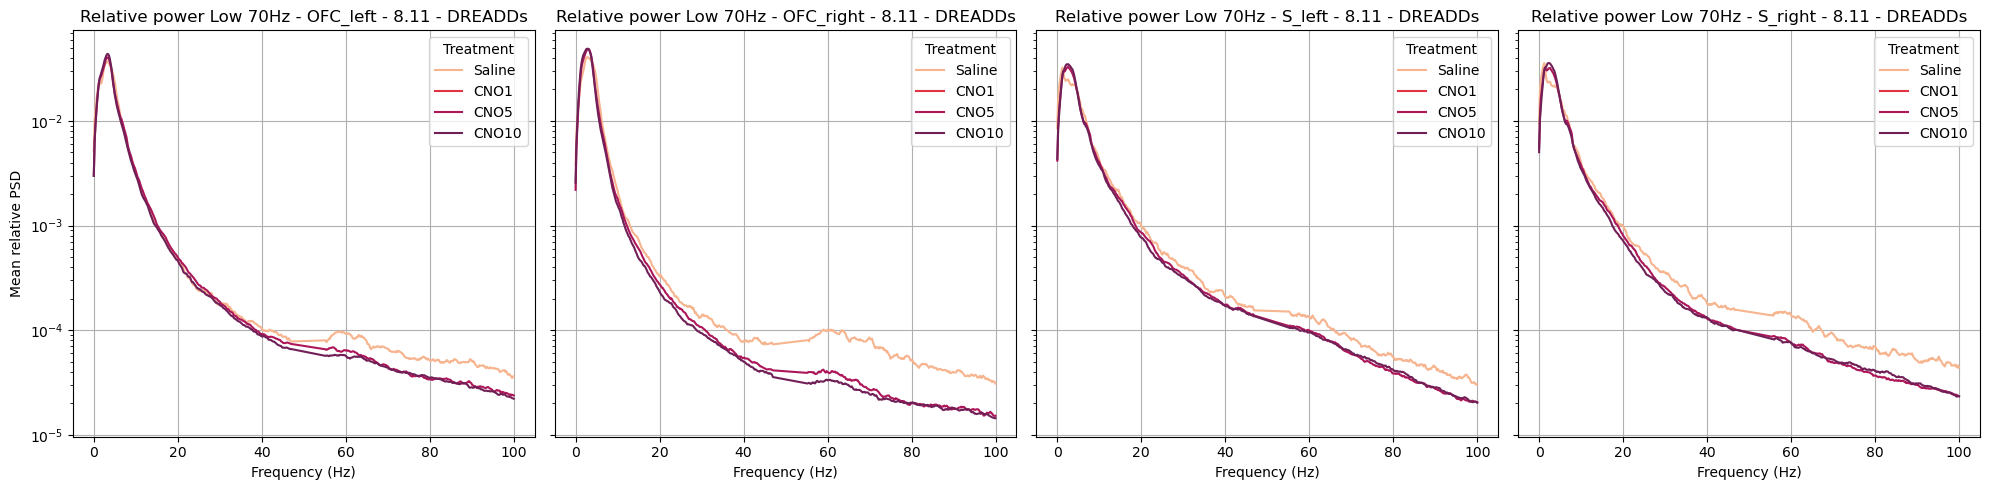

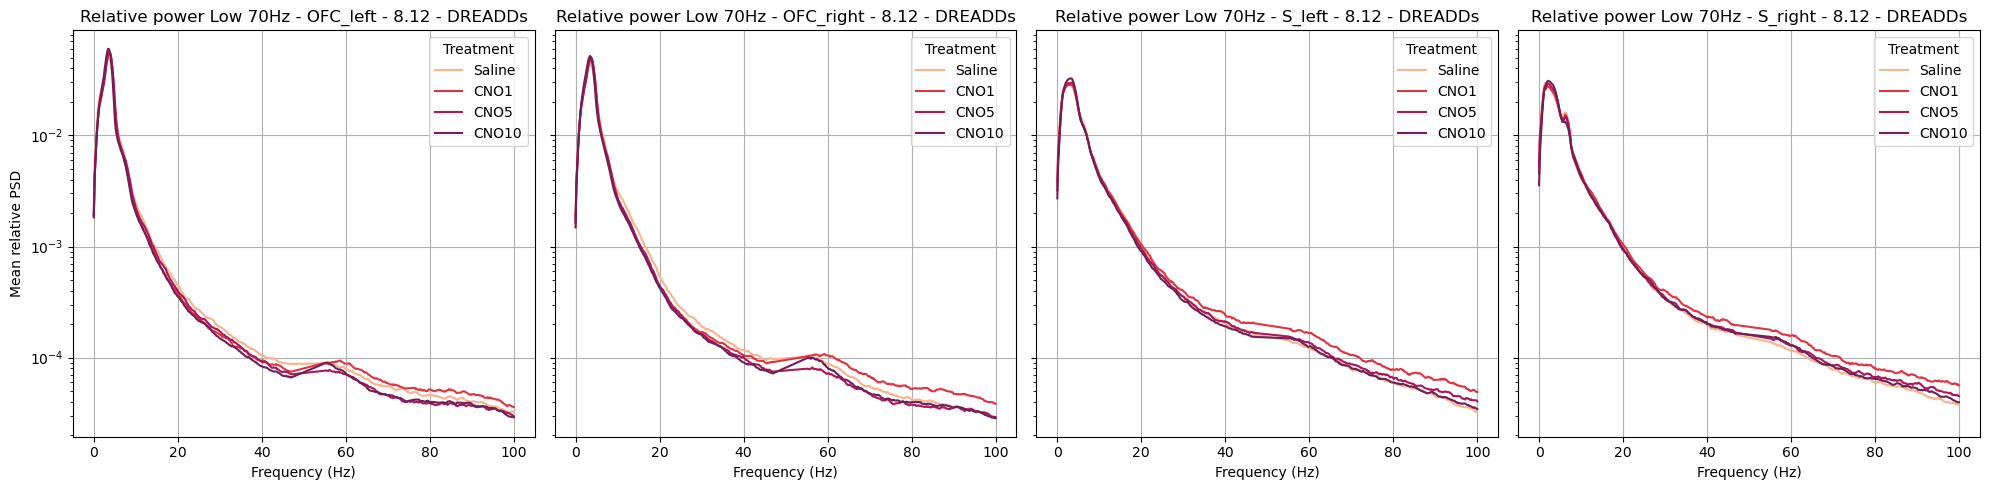

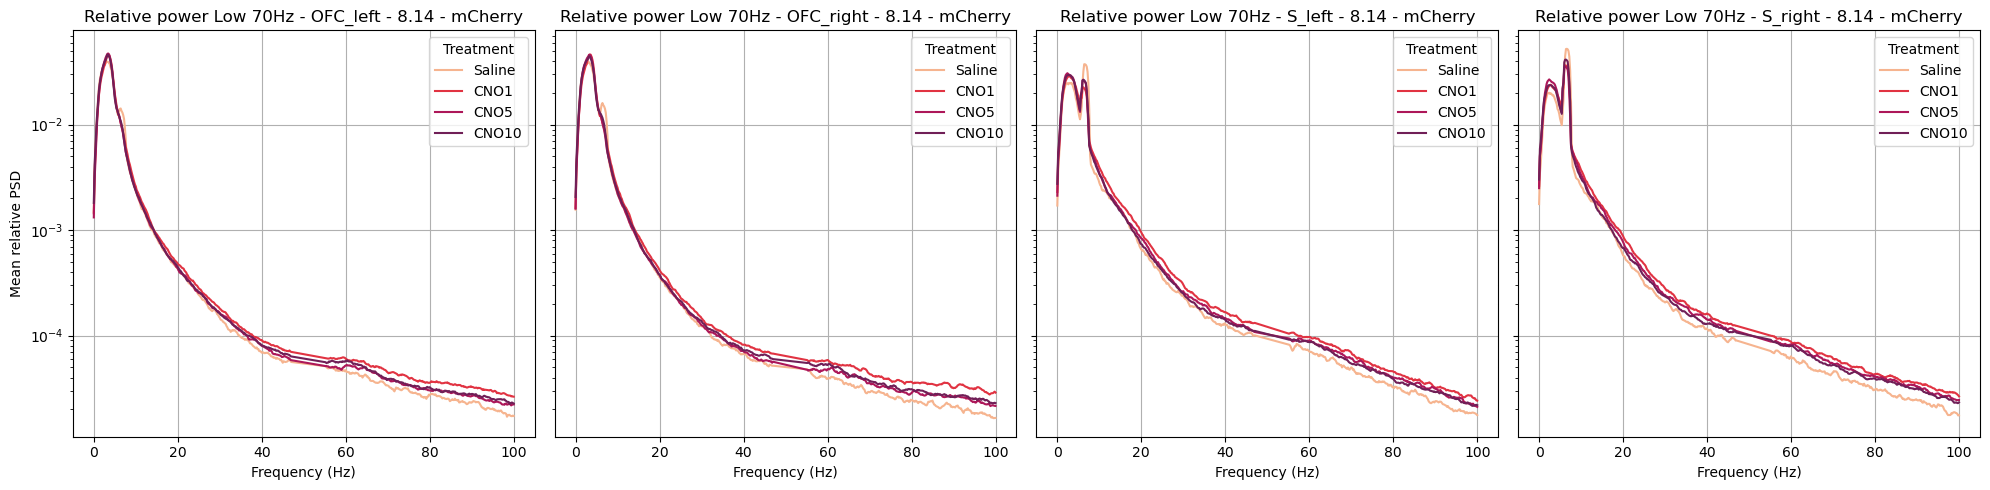

In [34]:
# Low 70 Hz
# Iterate over each animal
for animal_id in ['8.11','8.12', '8.14']:
    # Create a figure and axes for each animal
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)
    
    # Filter dataframe for the current anima & exclude noise frequencies
    animal_df_clean = cluster_low70Hz[(cluster_low70Hz['Animal'] == animal_id) & ((cluster_low70Hz['Freqs'] > 55) | (cluster_low70Hz['Freqs'] < 47))]
    surgery = cluster_low70Hz[cluster_low70Hz['Animal'] == animal_id]['Surgery'].unique()[0]

    # Iterate over each channel
    for i, channel in enumerate(channel_order):
        # Filter dataframe and plot for the current channel
        channel_df = animal_df_clean[animal_df_clean['Channel'] == channel]
        sns.lineplot(data=channel_df, x='Freqs', y='Mean_rel_PSD', hue='Treatment',  
                     hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
        axes[i].set_yscale('log')
        axes[i].set_title(f'Relative power Low 70Hz - {channel} - {animal_id} - {surgery}')
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylabel('Mean relative PSD')
        axes[i].grid(True)
        axes[i].legend(title='Treatment')

    plt.tight_layout()
    plt.show()   
    

### Relative Power (individual)

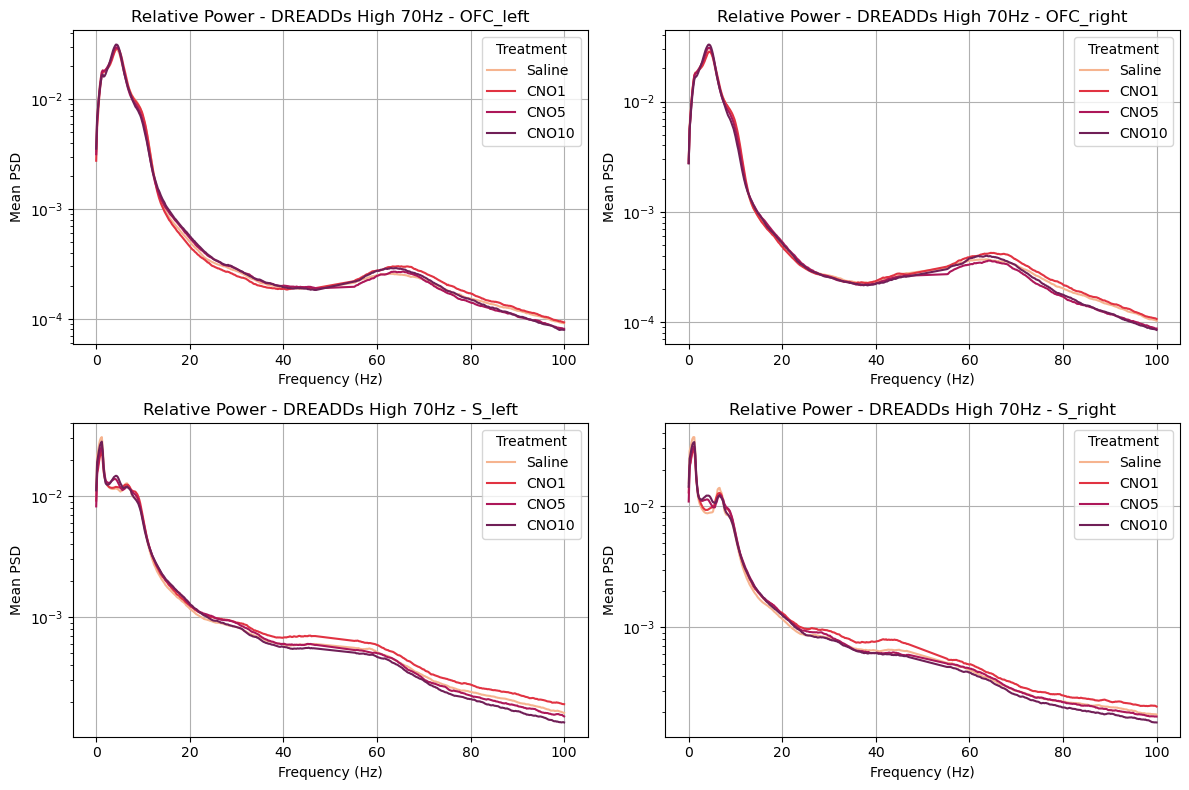

In [27]:
# dreadds high 70Hz
# plot individual RELATIVE, for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

for i, channel in enumerate(channel_order):
    # Take out the frequencies between 47-55 Hz
    dreadd_high_clean = dreadd_high[(dreadd_high['Freqs']>55) | (dreadd_high['Freqs']<47)]
    sns.lineplot(data=dreadd_high_clean[dreadd_high_clean["Channel"]==channel], x='Freqs', y='Mean_rel_PSD', hue='Treatment',
                 hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Relative Power - DREADDs High 70Hz - {channel}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Mean PSD')
    axes[i].grid(True)
    axes[i].legend(title='Treatment')

plt.tight_layout()  
plt.show()

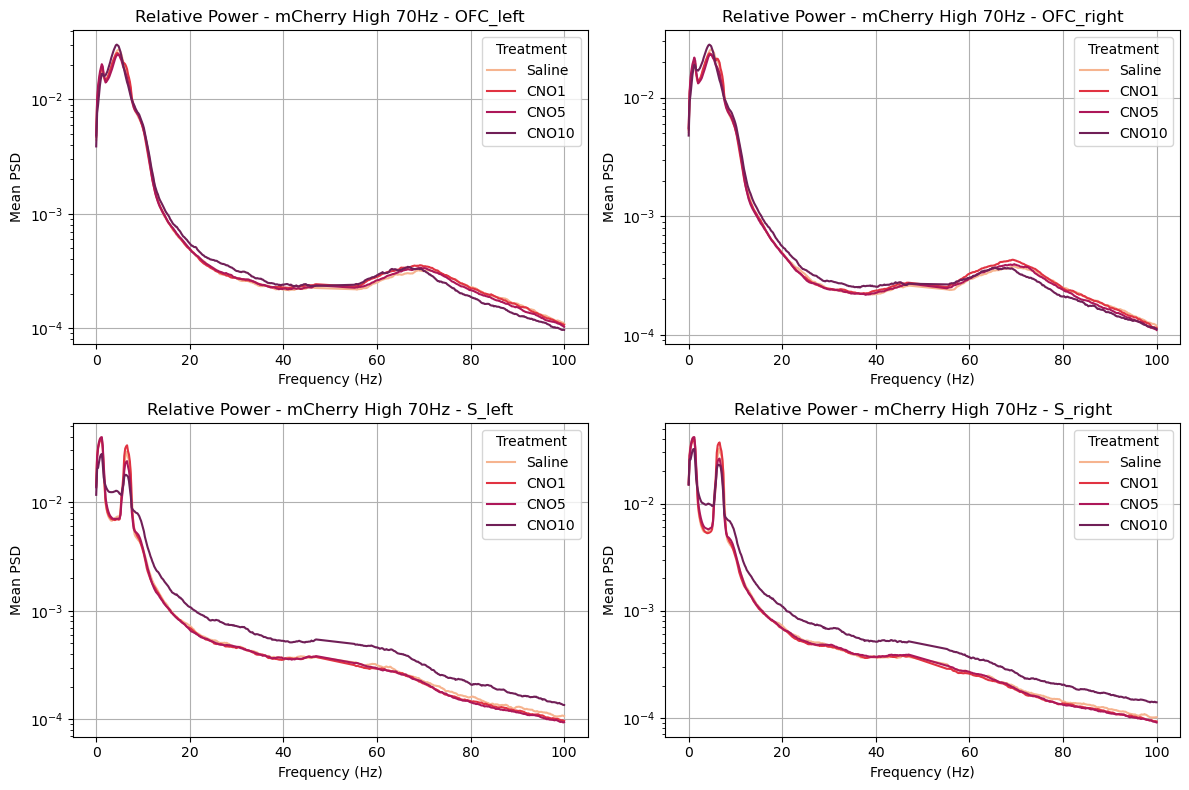

In [28]:
# mcherry high 70Hz
# plot individual RELATIVE, for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

for i, channel in enumerate(channel_order):
    # Take out the frequencies between 47-55 Hz
    mcherry_high_clean = mcherry_high[(mcherry_high['Freqs']>55) | (mcherry_high['Freqs']<47)]
    sns.lineplot(data=mcherry_high_clean[mcherry_high_clean["Channel"]==channel], x='Freqs', y='Mean_rel_PSD', hue='Treatment',
                 hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Relative Power - mCherry High 70Hz - {channel}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Mean PSD')
    axes[i].grid(True)
    axes[i].legend(title='Treatment')

plt.tight_layout()  
plt.show()

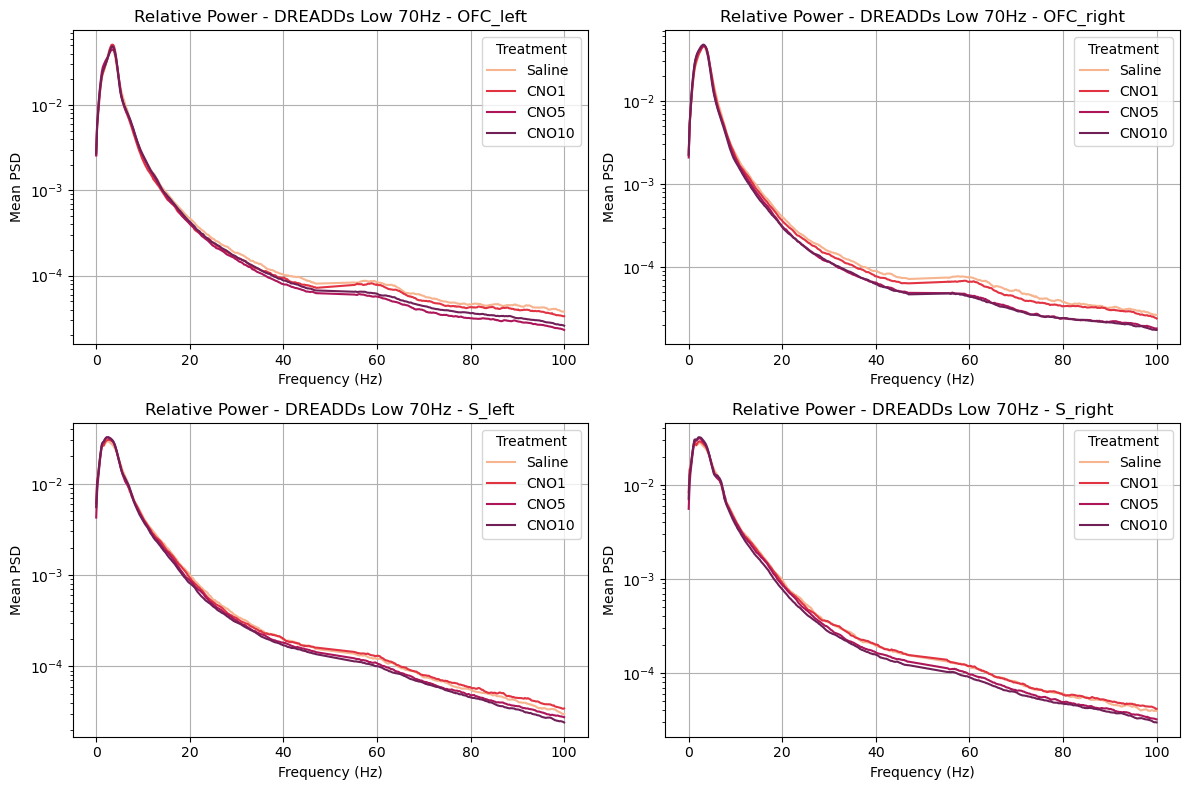

In [29]:
# dreadds low 70Hz
# plot individual RELATIVE, for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

for i, channel in enumerate(channel_order):
    # Take out the frequencies between 47-55 Hz
    dreadd_low_clean = dreadd_low[(dreadd_low['Freqs']>55) | (dreadd_low['Freqs']<47)]
    sns.lineplot(data=dreadd_low_clean[dreadd_low_clean["Channel"]==channel], x='Freqs', y='Mean_rel_PSD', hue='Treatment',
                 hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Relative Power - DREADDs Low 70Hz - {channel}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Mean PSD')
    axes[i].grid(True)
    axes[i].legend(title='Treatment')

plt.tight_layout()  
plt.show()

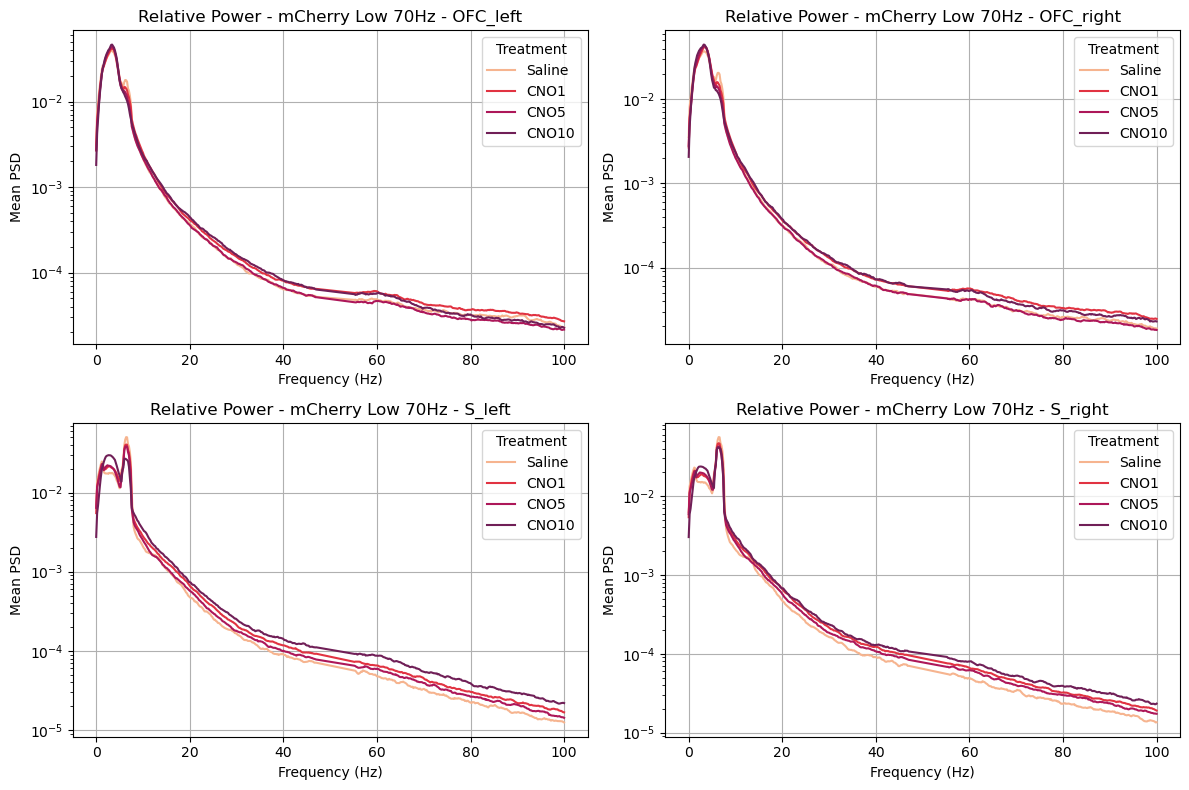

In [30]:
# mcherry low 70Hz
# plot individual RELATIVE, for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

for i, channel in enumerate(channel_order):
    # Take out the frequencies between 47-55 Hz
    mcherry_low_clean = mcherry_low[(mcherry_low['Freqs']>55) | (mcherry_low['Freqs']<47)]
    sns.lineplot(data=mcherry_low_clean[mcherry_low_clean["Channel"]==channel], x='Freqs', y='Mean_rel_PSD', hue='Treatment',
                 hue_order=legend_order, ax=axes[i], palette=custom_palette, errorbar=None)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Relative Power - mCherry Low 70Hz - {channel}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Mean PSD')
    axes[i].grid(True)
    axes[i].legend(title='Treatment')

plt.tight_layout()  
plt.show()

### Plots for online the saline condition

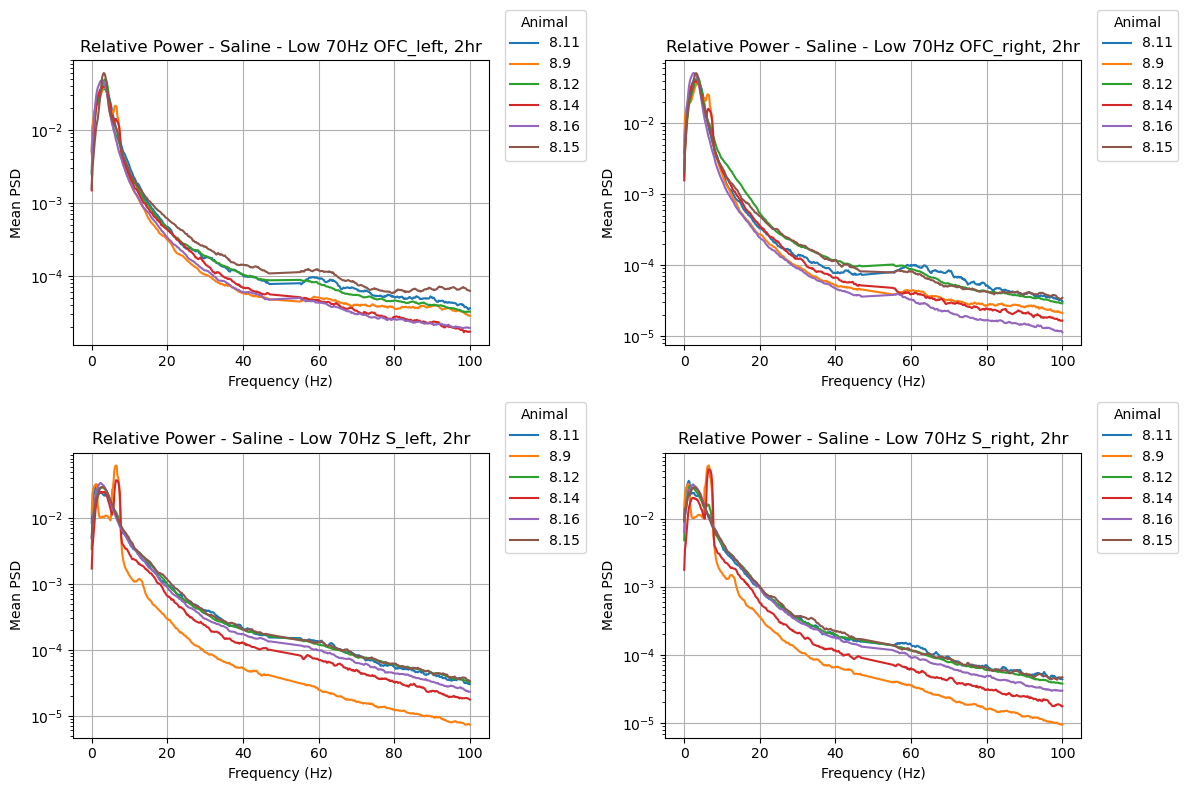

In [31]:
# Low 70Hz
# Plot RELATIVE power for all animals for saline condition
# Subset df for Saline treatment
saline_rel_data = cluster_low70Hz[cluster_low70Hz['Treatment'] == 'Saline']

# Create subplots for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

# Plot aggregated data for Saline treatment, with different animals as hue
for i, (channel, ax) in enumerate(zip(channel_order, axes)):
    cleaned = saline_rel_data[saline_rel_data['Channel'] == channel]

    # Take out the frequencies between 47-55 Hz
    cleaned = cleaned[(cleaned['Freqs']>55) | (cleaned['Freqs']<47)]
    sns.lineplot(data=cleaned[cleaned["Channel"]==channel], x='Freqs', y='Mean_rel_PSD',
                  hue='Animal', ax=ax, errorbar='se')
    ax.set_yscale('log')
    ax.set_title(f'Relative Power - Saline - Low 70Hz {channel}, {duration_hours}hr')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Mean PSD')
    ax.grid(True)
    ax.legend(title='Animal', bbox_to_anchor=(1.25, 1.2), loc='upper right')

plt.tight_layout()  
plt.show()

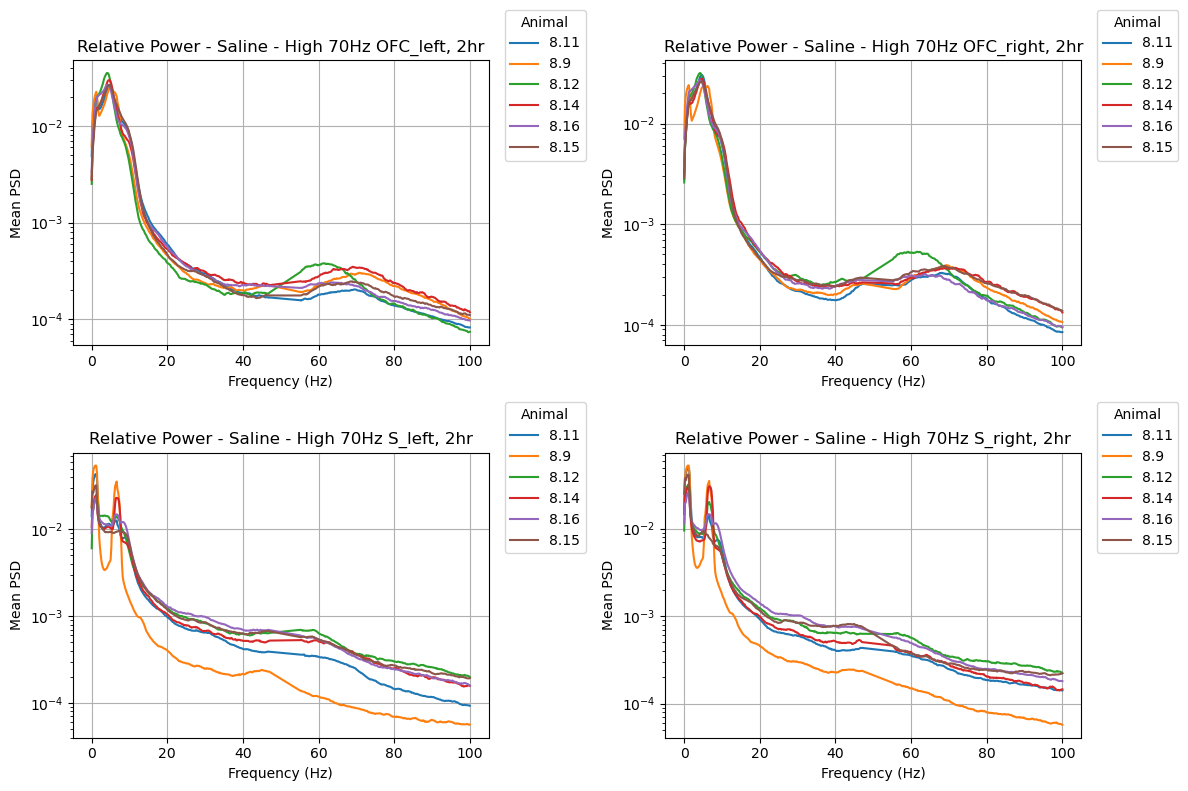

In [32]:
# High 70Hz
# Plot RELATIVE power for all animals for saline condition
# Subset df for Saline treatment
saline_rel_data = cluster_high70Hz[cluster_high70Hz['Treatment'] == 'Saline']

# Create subplots for each channel
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()

# Plot aggregated data for Saline treatment, with different animals as hue
for i, (channel, ax) in enumerate(zip(channel_order, axes)):
    cleaned = saline_rel_data[saline_rel_data['Channel'] == channel]

    # Take out the frequencies between 47-55 Hz
    cleaned = cleaned[(cleaned['Freqs']>55) | (cleaned['Freqs']<47)]
    sns.lineplot(data=cleaned[cleaned["Channel"]==channel], x='Freqs', y='Mean_rel_PSD',
                  hue='Animal', ax=ax, errorbar='se')
    ax.set_yscale('log')
    ax.set_title(f'Relative Power - Saline - High 70Hz {channel}, {duration_hours}hr')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Mean PSD')
    ax.grid(True)
    ax.legend(title='Animal', bbox_to_anchor=(1.25, 1.2), loc='upper right')

plt.tight_layout()  
plt.show()

### Power relative to saline condition

In [21]:
# Define function to plot PSD relative to saline
def plot_rel_psd(data, errorbar='ci', min_noise_freq=47, max_noise_freq=55):
    """ 
    Takes:
    The data 
    The type of errorbar (standard: confidence interval), 
    The frequencies between minimum and maximum noise frequencies (standard 47 and 55) are taken out
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.ravel()

    # Extract unique values for dynamic plot titles
    surgery = data['Surgery'].unique()[0]
    cluster_label = data['Cluster_Label'].unique()[0]

    for i, channel in enumerate(channel_order):
        cleaned = data[data['Channel'] == channel]
        # Remove frequencies between min_noise_freq and max_noise_freq
        cleaned = cleaned[(cleaned['Freqs'] > max_noise_freq) | (cleaned['Freqs'] < min_noise_freq)]
        sns.lineplot(data=cleaned, x='Freqs', y='normalized_power', hue='Treatment',  ax=axes[i],  
                     errorbar=errorbar, hue_order=legend_order, palette=custom_palette)

        axes[i].set_ylim(0, 200)
        axes[i].set_title(f'Relative Power - {surgery} - {cluster_label} - {channel}, {duration_hours}hr')
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylabel('Relative Mean PSD (%)')
        axes[i].grid(True)
        axes[i].legend(title='Treatment')

    plt.tight_layout()
    plt.show()

Plots

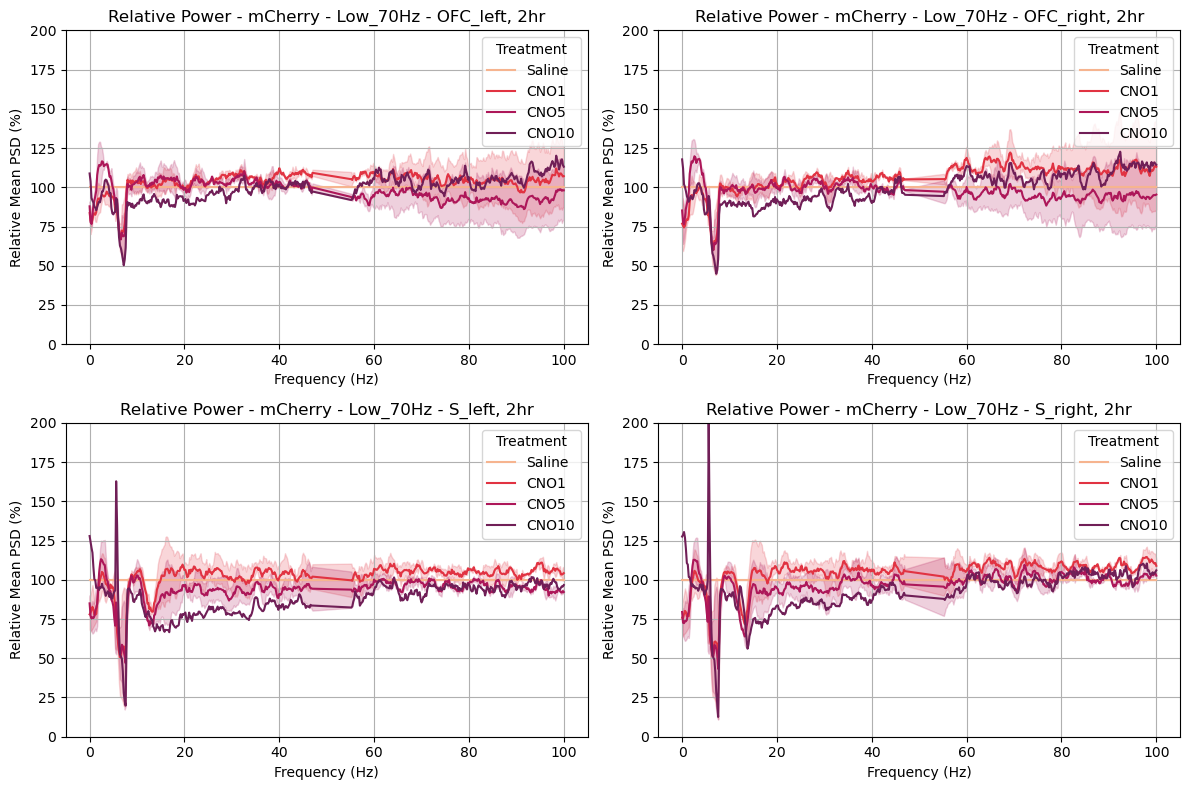

In [22]:
plot_rel_psd(mcherry_norm_low, 'ci', 47, 55)


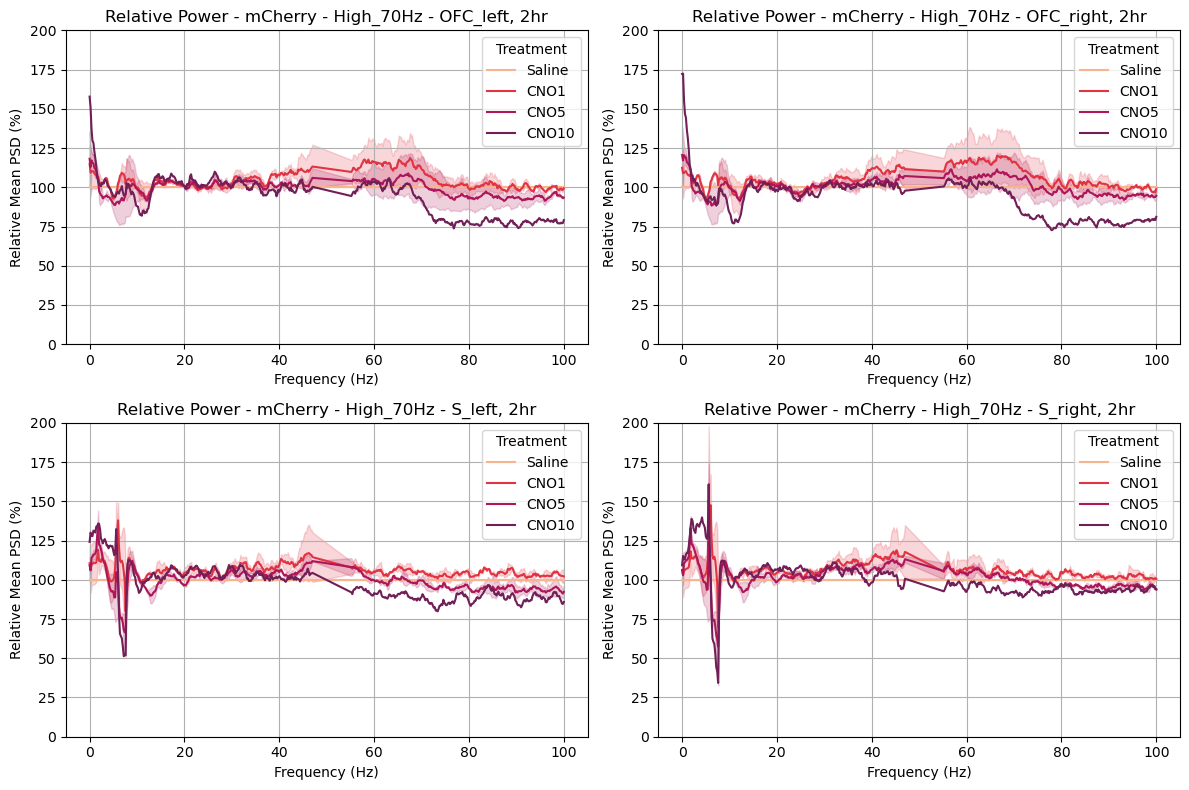

In [23]:
plot_rel_psd(mcherry_norm_high, 'ci', 47, 55)


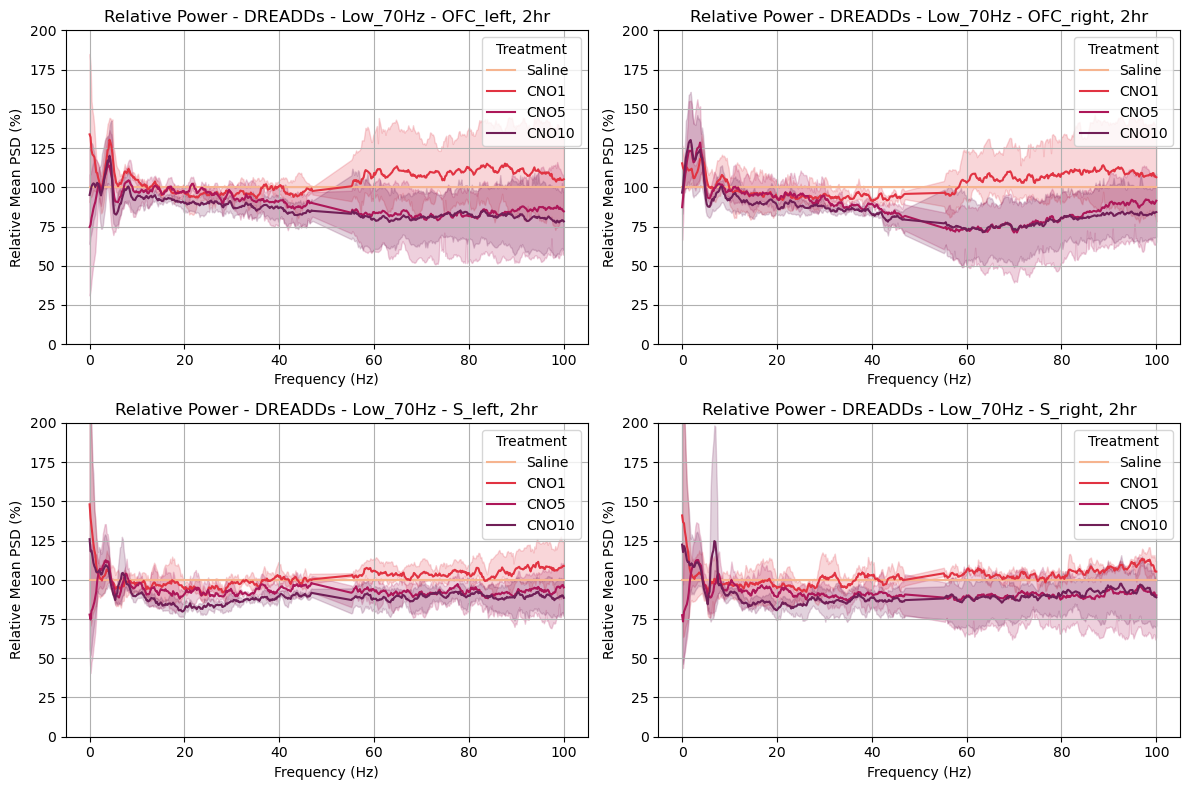

In [24]:
plot_rel_psd(dreadd_norm_low, 'ci', 47, 55)


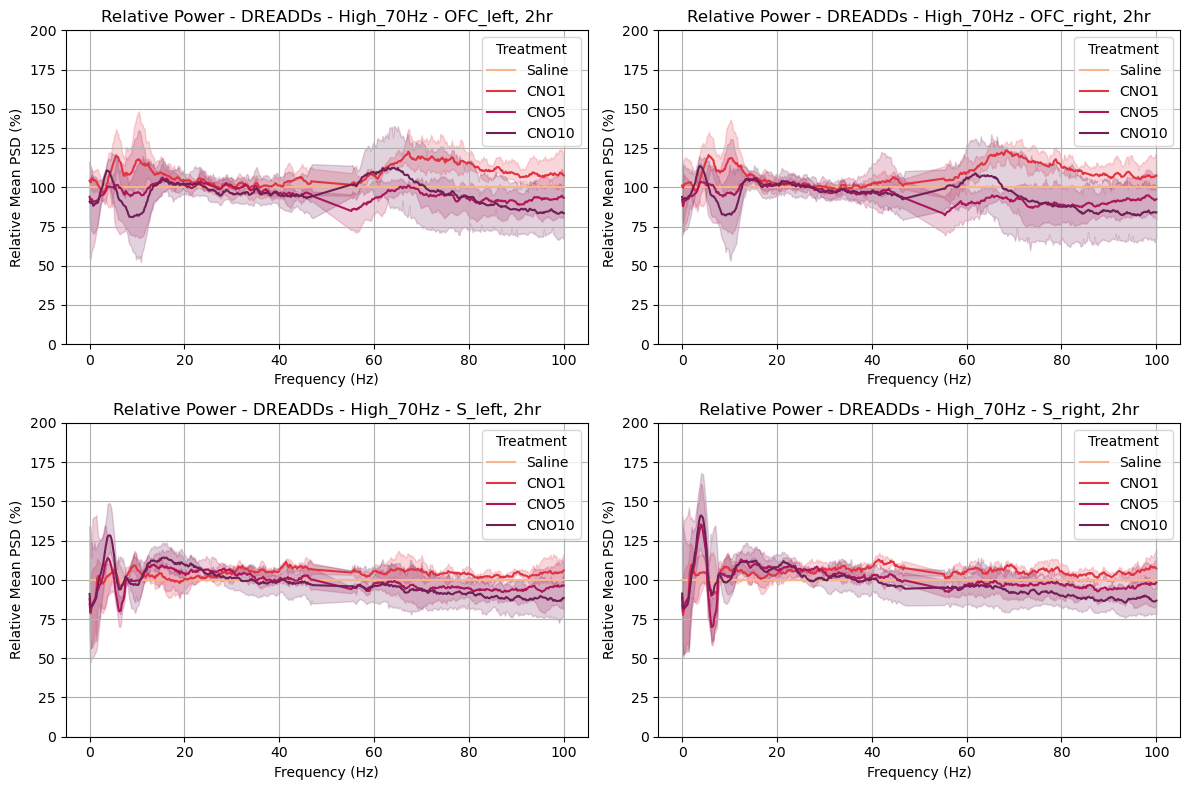

In [25]:
plot_rel_psd(dreadd_norm_high, 'ci', 47, 55)
